In [271]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

In [272]:
df = pd.read_excel('data/texaco_data.xlsx')
df1 = df.loc[df['C'] > 0][:3]
print(df1)

     n  fuel_rate  o2_fuel  steam_fuel  water_coal       C      H     O     N  \
0  I-1     76.660    0.866       0.241         0.0  74.050  6.250  1.32  1.77   
1  I-2     81.180    0.768       0.314         0.0  73.040  5.820  1.70  0.73   
2  I-3     82.202    0.813       0.309         0.0  73.545  6.035  1.51  1.25   

      S  ...   CO_m   H2_m  CO2_m  H2O_m  CH4_m  H2S_m   N2_m   soma   soma_m  \
0  0.71  ...  56.60  39.84   2.92    0.0  0.160  0.270  0.208  99.95   99.998   
1  1.37  ...  54.11  41.39   3.89    0.0  0.193  0.212  0.207  99.95  100.002   
2  1.04  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   0.00    0.000   

   soma_fuel  
0    100.000  
1     99.970  
2     99.985  

[3 rows x 45 columns]


In [273]:
def HHV_correlation(ultimate, ash): # Correlation from Silva et al. 2019 - 10.1016/j.rser.2019.109305
    A = ash * 100
    C = ultimate[0] / sum(ultimate) * (100 - A)
    H = ultimate[1] / sum(ultimate) * (100 - A)
    O = ultimate[2] / sum(ultimate) * (100 - A)
    N = ultimate[3] / sum(ultimate) * (100 - A)
    S = ultimate[4] / sum(ultimate) * (100 - A)
    Cl = ultimate[5] / sum(ultimate) * (100 - A)
    HHV = 0.3491*C + 1.1783*H + 0.1005*S - 0.1034*O - 0.0151*N - 0.0211*A
    return HHV
    

In [274]:
P = 24*ct.one_atm # 24 atm = 2 431 800 Pa
T0 = 230 + 273.15 # 450 °F = 230 °C = 503.15 # K
species = ['CO', 'H2', 'CO2', 'CH4', 'H2S', 'N2']
fracs = np.zeros((len(df1), len(species)))
rates = np.zeros((len(df1), len(species)))
c = 0

for i, row in df1.iterrows():
    # Fuel
    ultimate = [row['C'], row['H'], row['O'], row['N'], row['S'], row['Cl']]
    ash = row['ash'] / 100
    HHV = HHV_correlation(ultimate,ash)
    fuelRate = row['fuel_rate'] / 1000 # kg/s
    feed = fs.create_fuel_stream(fuelRate, ultimate, ash, moisture=0, HHV=HHV)

    # Gasifying agent
    oxyRatio = row['o2_fuel']
    steamRatio = row['steam_fuel']
    waterRatio = row['water_coal']

    oxygen = fs.create_O2_stream(oxyRatio*fuelRate)
    steam = fs.create_steam_stream(steamRatio*fuelRate)

    agent = fs.combine_streams(oxygen, steam)

    outlet_non = gs.gasify_nonisot(feed, agent, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)

    for j, sp in enumerate(species):
        fracs[c,j] = 100*outlet_non.get_syngas_fraction(sp, water=False, nitrogen=True) # % mol/mol
        rates[c,j] = outlet_non.species_moles[phases.indices[sp]] * phases.Mw[sp] * 1000 # g/s

    c += 1

print(fracs)

[[5.83014764e+01 3.88432596e+01 2.19120573e+00 3.17372194e-02
  2.57738099e-03 6.19357885e-01]
 [5.63677744e+01 4.00371751e+01 2.64734680e+00 6.75508786e-01
  1.15769778e-02 2.54448966e-01]
 [5.63684202e+01 4.01840036e+01 2.82958060e+00 1.69459275e-01
  9.27164365e-03 4.31508717e-01]]


In [275]:
exp_frac = df1[species]
avg_exp_frac = np.array(exp_frac.mean(0))
author_frac = df1[['CO_m', 'H2_m', 'CO2_m', 'CH4_m', 'H2S_m', 'N2_m']]
avg_author_frac = np.array(author_frac.mean(0))
avg_model_frac = np.mean(fracs, 0)

In [276]:
exp_rate = df1[['CO_f', 'H2_f', 'CO2_f', 'CH4_f', 'H2S_f', 'N2_f']]
avg_exp_rate = np.array(exp_rate.mean(0))
author_rate = df1[['CO_fm', 'H2_fm', 'CO2_fm', 'CH4_fm', 'H2S_fm', 'N2_fm']]
avg_author_rate = np.array(author_rate.mean(0))
avg_model_rate = np.mean(rates, 0)

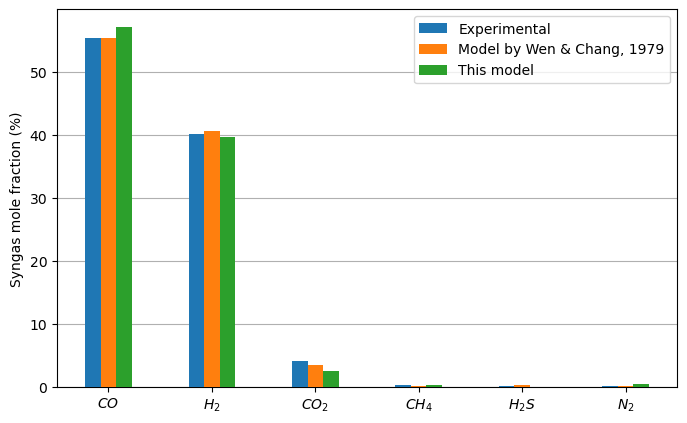

In [277]:
frac_groups = ['$CO$', '$H_2$', '$CO_2$', '$CH_4$', '$H_2S$','$N_2$']

X_axis1 = np.arange(len(frac_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
ax1.bar(X_axis1 - w, avg_exp_frac, w, label='Experimental', zorder=3)
ax1.bar(X_axis1, avg_author_frac, w, label='Model by Wen & Chang, 1979', zorder=3)
ax1.bar(X_axis1 + w, avg_model_frac, w, label='This model', zorder=3)
ax1.set_ylabel("Syngas mole fraction (%)")
ax1.grid(zorder=0, axis='y')
plt.xticks(X_axis1, frac_groups)
# plt.yscale('log')
plt.legend(loc='best')
plt.savefig('figures/wen1.png')
plt.show()

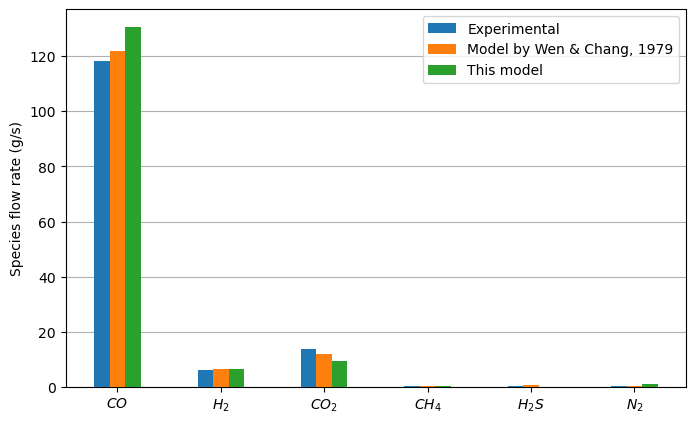

In [278]:
rate_groups = ['$CO$', '$H_2$', '$CO_2$', '$CH_4$', '$H_2S$','$N_2$']

X_axis1 = np.arange(len(rate_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
ax1.bar(X_axis1 - w, avg_exp_rate, w, label='Experimental', zorder=3)
ax1.bar(X_axis1, avg_author_rate, w, label='Model by Wen & Chang, 1979', zorder=3)
ax1.bar(X_axis1 + w, avg_model_rate, w, label='This model', zorder=3)
ax1.set_ylabel("Species flow rate (g/s)")
ax1.grid(zorder=0, axis='y')
plt.xticks(X_axis1, rate_groups)
# plt.yscale('log')
plt.legend(loc='best')
plt.savefig('figures/wen2.png')
plt.show()

In [279]:
I1 = df[df['n'] == 'I-1']
ultimate = [float(I1['C']), float(I1['H']), float(I1['O']), float(I1['N']), float(I1['S']), float(I1['Cl'])]
ash = float(I1['ash']) / 100
HHV = HHV_correlation(ultimate, ash)
feed = fs.create_fuel_stream(1, ultimate, ash, moisture=0, HHV=HHV)

P = 24*ct.one_atm
T0 = 230+273.15
oxyRatio = 0.866
oxygen = fs.create_O2_stream(oxyRatio * feed.get_mass())
SRs = np.arange(0.1, 0.6+1E-9, 0.01)

CO = np.zeros_like(SRs)
H2 = np.zeros_like(SRs)
CO2 = np.zeros_like(SRs)

for i, sr in enumerate(SRs):
    steam = fs.create_steam_stream(sr * feed.get_mass())
    agent = fs.combine_streams(oxygen, steam)
    outlet = gs.gasify_nonisot(feed, agent, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    CO[i] = 100*outlet.get_syngas_fraction('CO', water=False, nitrogen=True)
    H2[i] = 100*outlet.get_syngas_fraction('H2', water=False, nitrogen=True)
    CO2[i] = 100*outlet.get_syngas_fraction('CO2', water=False, nitrogen=True)

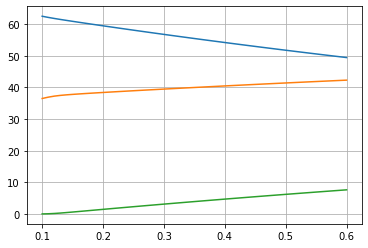

In [280]:
plt.plot(SRs, CO)
plt.plot(SRs, H2)
plt.plot(SRs, CO2)
plt.grid()
plt.show()

In [281]:
I1 = df[df['n'] == 'I-1']
ultimate = [float(I1['C']), float(I1['H']), float(I1['O']), float(I1['N']), float(I1['S']), float(I1['Cl'])]
ash = float(I1['ash']) / 100
HHV = HHV_correlation(ultimate, ash)
feed = fs.create_fuel_stream(1, ultimate, ash, moisture=0, HHV=HHV)

P = 24*ct.one_atm
T0 = 230+273.15
steamRatio = 0.314
steam = fs.create_steam_stream(steamRatio * feed.get_mass())
ORs = np.arange(0.5, 0.9+1E-9, 0.01)

CO = np.zeros_like(ORs)
H2 = np.zeros_like(ORs)
CO2 = np.zeros_like(ORs)

for i, oxy in enumerate(ORs):
    oxygen = fs.create_O2_stream(oxy * feed.get_mass())
    agent = fs.combine_streams(oxygen, steam)
    outlet = gs.gasify_nonisot(feed, agent, T0=T0, P=P, heatLossFraction=0, charFormation=0, directMethaneConv=0)
    CO[i] = 100*outlet.get_syngas_fraction('CO', water=False, nitrogen=True)
    H2[i] = 100*outlet.get_syngas_fraction('H2', water=False, nitrogen=True)
    CO2[i] = 100*outlet.get_syngas_fraction('CO2', water=False, nitrogen=True)

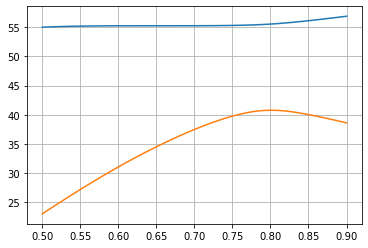

In [284]:
plt.plot(ORs, CO)
plt.plot(ORs, H2)
# plt.plot(ORs, CO2)
plt.grid()
plt.show()